## PySM 3 dust templates based on Planck GNILC maps

The purpose of this notebook is to pre-process galactic dust maps from the [Planck analysis with GNILC](https://arxiv.org/abs/1605.09387)
to create a dust model for PySM 3 which is based on real data at large scale and has added gaussian fluctuations at small scales.

These dust maps, compared to the commander results used by the `d1` model of PySM 2, have the CIB signal removed and less noise.
This notebook focuses only on the IQU templates at 353 GHz, "dust temperature" and "dust spectral index" will be processed separately.

In [100]:
import os
os.environ["OMP_NUM_THREADS"] = "64" # for jupyter.nersc.gov otherwise the notebook only uses 2 cores

In [2]:
import os
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
%matplotlib inline

In [3]:
hp.disable_warnings()

In [4]:
plt.style.use("seaborn-talk")

In [5]:
import pysm3 as pysm
import pysm3.units as u

In [6]:
nside = 2048
degraded_nside = 2048 # to speedup notebook for testing
lmax = 1000

In [7]:
# comp = "I"
comp = "IQU"

In [8]:
components = list(enumerate(comp))
components

[(0, 'I'), (1, 'Q'), (2, 'U')]

In [9]:
spectra_components = ["II", "EE", "BB"]

## Masks

Using the Planck Common mask for polarization from the 3rd release:

https://irsa.ipac.caltech.edu/data/Planck/release_3/ancillary-data/previews/COM_Mask_CMB-common-Mask-Pol_2048_R3.00/index.html

and also the one for temperature and create a union mask of the 2, as we will be processing both polarization and intensity together.

In [10]:
planck_mask_filename_QU = "COM_Mask_CMB-common-Mask-Pol_2048_R3.00.fits" 

In [11]:
planck_mask_filename_I = "COM_Mask_CMB-common-Mask-Int_2048_R3.00.fits"

In [12]:
planck_mask_filenames= [planck_mask_filename_QU, planck_mask_filename_I]

In [13]:
for planck_mask_filename in [planck_mask_filename_QU, planck_mask_filename_I]:
    if not os.path.exists(os.path.join("data", planck_mask_filename)):
        !wget -O data/$planck_mask_filename https://irsa.ipac.caltech.edu/data/Planck/release_3/ancillary-data/masks/$planck_mask_filename

In [14]:
fits.open("data/" + planck_mask_filename_QU)[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                    4 / width of table in bytes                        
NAXIS2  =             50331648 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    1 / number of fields in each row                   
COMMENT  -------------------------------------------------------------          
COMMENT  Further details in the Planck Legacy Archive and Explanatory Supplement
COMMENT  http://www.cosmos.esa.int/web/planck/pla/                              
COMMENT  -------------------------------------------------------------          
COMMENT                     

In [15]:
planck_mask = np.logical_and(*[hp.read_map(os.path.join("data", planck_mask_filename)) for  planck_mask_filename in planck_mask_filenames])

In [16]:
np.unique(planck_mask) # no apodization

array([False,  True])

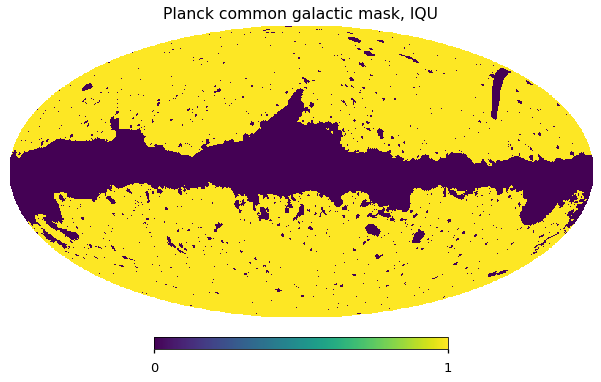

In [17]:
hp.mollview(planck_mask, title=f"Planck common galactic mask, {comp}")

## Planck GNILC dust

Downloaded from the Planck Legacy Archive (PLA), the [GNILC templates](https://wiki.cosmos.esa.int/planck-legacy-archive/index.php/Foreground_maps#GNILC_thermal_dust_maps) are available either at a single resolution of 80 arcminutes or at variable resolution, where regions of higher emission have 5 arcmin resolution. Here we want to fit the slope of the small scales therefore we want the variable resolution image which has the least smoothing applied.

Rename `varres` to `unires` in the filename to use the 80 arcmin uniform resolution map instead.

In [18]:
dust_map_filename = "COM_CompMap_IQU-thermaldust-gnilc-varres_2048_R3.00.fits"
dust_map_path = os.path.join("data", dust_map_filename)

In [19]:
if not os.path.exists(dust_map_path):
    !wget -O $dust_map_path http://pla.esac.esa.int/pla/aio/product-action?MAP.MAP_ID=$dust_map_filename

--2021-02-02 16:04:00--  http://pla.esac.esa.int/pla/aio/product-action?MAP.MAP_ID=COM_CompMap_IQU-thermaldust-gnilc-varres_2048_R3.00.fits
Resolving pla.esac.esa.int (pla.esac.esa.int)... 193.147.153.153
Connecting to pla.esac.esa.int (pla.esac.esa.int)|193.147.153.153|:80... connected.
HTTP request sent, awaiting response... 200 
Length: unspecified [image/fits]
Saving to: ‘data/COM_CompMap_IQU-thermaldust-gnilc-varres_2048_R3.00.fits’

data/COM_CompMap_IQ     [               <=>  ]   1.88G  8.80MB/s    in 3m 43s  

2021-02-02 16:07:45 (8.61 MB/s) - ‘data/COM_CompMap_IQU-thermaldust-gnilc-varres_2048_R3.00.fits’ saved [2013275520]



In [101]:
# dust_map_R2_filename = "COM_CompMap_Dust-GNILC-F353_2048_R2.00.fits"
# dust_map_R2_path = os.path.join("data", dust_map_R2_filename)
# if "varres" in dust_map_filename:
#    if not os.path.exists(dust_map_R2_path):
#        !wget -O $dust_map_R2_path http://pla.esac.esa.int/pla/aio/product-action?MAP.MAP_ID=$dust_map_R2_filename

In [20]:
fits.open(dust_map_path).info()

Filename: data/COM_CompMap_IQU-thermaldust-gnilc-varres_2048_R3.00.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       7   ()      
  1                1 BinTableHDU     71   50331648R x 10C   [1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E]   


In [21]:
m_planck,h = hp.read_map(dust_map_path, [c+"_STOKES" for c in comp], h=True)

In [22]:
if degraded_nside != nside:
    m_planck = hp.ud_grade(m_planck, degraded_nside)

In [23]:
h

[('XTENSION', 'BINTABLE'),
 ('BITPIX', 8),
 ('NAXIS', 2),
 ('NAXIS1', 40),
 ('NAXIS2', 50331648),
 ('PCOUNT', 0),
 ('GCOUNT', 1),
 ('TFIELDS', 10),
 ('COMMENT', ' -------------------------------------------------------------'),
 ('COMMENT', ' Products from GNILC component separation method'),
 ('COMMENT', ' -------------------------------------------------------------'),
 ('COMMENT',
  ' Further details in the Planck Legacy Archive and Explanatory Supplement'),
 ('COMMENT', ' http://www.cosmos.esa.int/web/planck/pla/'),
 ('COMMENT', ' -------------------------------------------------------------'),
 ('COMMENT', ''),
 ('COMMENT', ' *** Planck params ***'),
 ('COMMENT', ''),
 ('EXT-NAME', 'COMP-MAP'),
 ('AST-COMP', 'THERMAL DUST'),
 ('PIXTYPE', 'HEALPIX'),
 ('COORDSYS', 'GALACTIC'),
 ('POLCCONV', 'COSMO'),
 ('ORDERING', 'NESTED'),
 ('NSIDE', 2048),
 ('METHOD', 'GNILC'),
 ('UNITFREQ', 'GHz'),
 ('BANDCTR', 353.0),
 ('RESTFREQ', 353.0),
 ('BNDWID', 0.0),
 ('BAD_DATA', -1.6375e+30),
 ('DATE'

Input units are $K_{CMB}$, PySM templates use $\mu K_{RJ}$

In [24]:
m_planck <<= u.K_CMB

In [25]:
m_planck = m_planck.to("uK_RJ", equivalencies=u.cmb_equivalencies(353*u.GHz))

In [26]:
if m_planck.ndim == 1:
    m_planck = m_planck.reshape((1,-1))

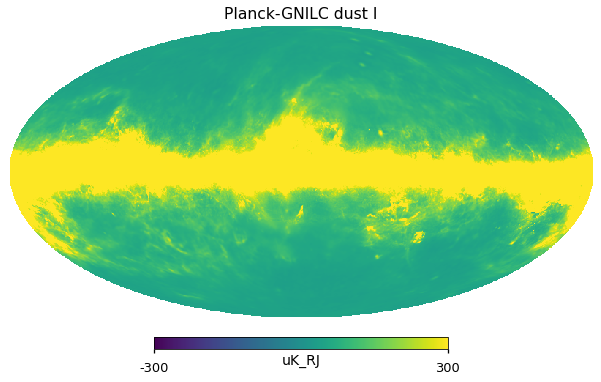

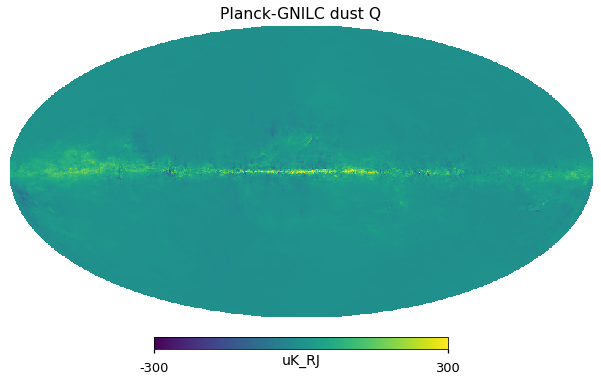

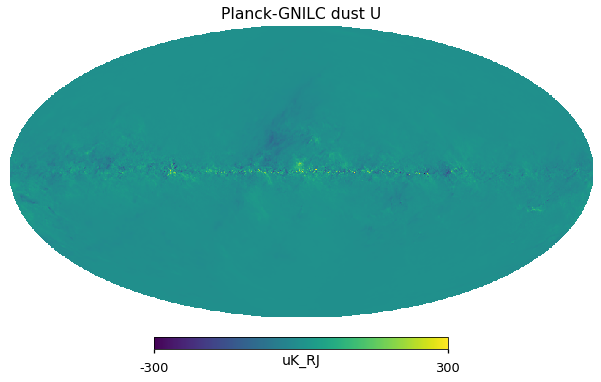

In [27]:
for i_pol, pol in components:
    hp.mollview(m_planck[i_pol], title="Planck-GNILC dust " + pol, unit=m_planck.unit, min=-300, max=300)

## Build the log of the polarization tensor

I - PxP and polarization fraction

  $
    \left[ \begin{array}{cc} i+q & u \\ u & i-q \end{array} \right] \ = \
    \ln \left[ \begin{array}{cc} I+Q & U \\ U & I-Q \end{array} \right]
  $


$
    i = \frac{1}{2}\, \ln \left(I^2-P^2\right), \hspace{1em}
    q = \frac{1}{2}\, \frac{Q}{P}\, \ln \frac{I+P}{I-P}, \hspace{1em}
    u = \frac{1}{2}\, \frac{U}{P}\, \ln \frac{I+P}{I-P}
$

$    I = e^{i} \cosh p, \hspace{2em}
    Q = \frac{q}{p} e^{i} \sinh p, \hspace{2em}
    U = \frac{u}{p} e^{i} \sinh p
$


In [28]:
def map_to_log_pol_tens(m):
    P = np.sqrt(m[1]**2 + m[2]**2)
    log_pol_tens = np.empty_like(m)
    log_pol_tens[0] = np.log(m[0]**2 - P**2)/2.0
    log_pol_tens[1:] = m[1:]/P * np.log((m[0]+P)/(m[0]-P))/2.0
    return log_pol_tens

In [29]:
def log_pol_tens_to_map(log_pol_tens):
    P = np.sqrt(log_pol_tens[1]**2 + log_pol_tens[2]**2)
    m = np.empty_like(log_pol_tens)
    m[0] = np.exp(log_pol_tens[0]) * np.cosh(P)
    m[1:] = log_pol_tens[1:]/P * np.exp(log_pol_tens[0]) * np.sinh(P)
    return m

In [30]:
log_pol_tens = map_to_log_pol_tens(m_planck.value)

In [31]:
m_back = log_pol_tens_to_map(log_pol_tens)

In [32]:
m_back - m_planck.value

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.42108547e-14, -1.42108547e-14,  0.00000000e+00],
       [ 1.41553436e-15,  5.99520433e-15, -5.41233725e-16, ...,
         4.44089210e-16, -3.99680289e-15, -2.77555756e-17],
       [-3.19189120e-15, -1.27675648e-15,  1.38777878e-15, ...,
        -4.10782519e-15,  3.10862447e-15,  0.00000000e+00]])

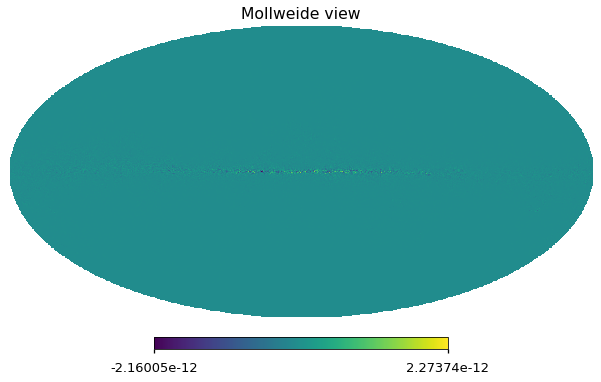

In [33]:
hp.mollview((m_back - m_planck.value)[1])

In [34]:
del m_back

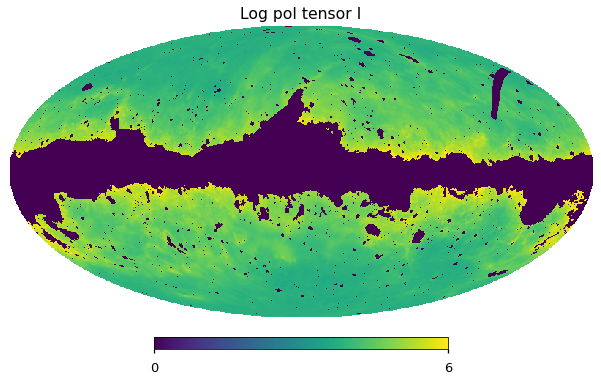

In [73]:
hp.mollview(log_pol_tens[0], title="Log pol tensor I", max=6)

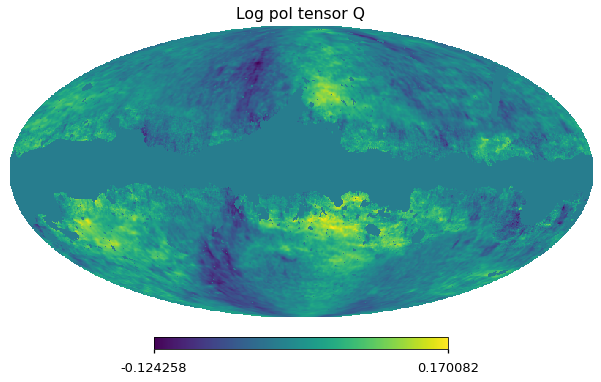

In [70]:
hp.mollview(log_pol_tens[1], title="Log pol tensor Q")

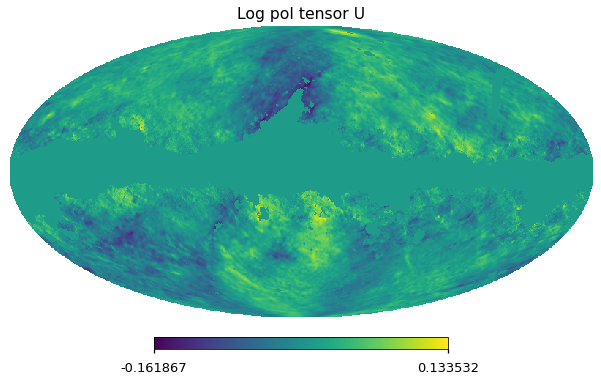

In [71]:
hp.mollview(log_pol_tens[2], title="Log pol tensor U")

## Angular power spectrum with `namaster`

We use `namaster` to estimate the power spectrum of the masked map,
compared to `anafast`, `namaster` properly deconvolves the mask to remove the
correlations between different $C_\ell$ caused by the mask.

We don't need to deconvolve the beam, we won't be using the values at high $\ell$ anyway.

In [35]:
import pymaster as nmt

In [36]:
f_2 = nmt.NmtField(planck_mask, log_pol_tens[1:])

In [37]:
binning = nmt.NmtBin(nside=degraded_nside, nlb=1, lmax=lmax, is_Dell=False)

In [38]:
cl_namaster = nmt.compute_full_master(f_2, f_2, binning)

In [39]:
cl = {}
cl["EE"] = np.concatenate([[0,0], cl_namaster[0]])
cl["BB"] = np.concatenate([[0,0], cl_namaster[3]])

In [40]:
hp.write_cl(f"data/cl_gnilc_log_pol_tens_pol.fits", cl_namaster, overwrite=True)
# cl_namaster = hp.read_cl("cl_gnilc_varres.fits")

In [41]:
f_0 = nmt.NmtField(planck_mask, log_pol_tens[:1])
cl_namaster_I = nmt.compute_full_master(f_0, f_0, binning)

In [42]:
hp.write_cl(f"data/cl_gnilc_log_pol_tens_temp.fits", cl_namaster_I, overwrite=True)

In [74]:
cl["II"] = np.concatenate([[0,0], cl_namaster_I[0]])

In [75]:
ell = np.concatenate([[0,1], binning.get_effective_ells()])
cl_norm = ell*(ell+1)/np.pi/2

In [76]:
cl_norm[0] = 1

The maps are smoothed (with different beams in different regions), so we try to select the region of $\ell$ which is roughtly linear in `loglog` scale just before the curvature of the smoothing looks to start dominating. We will use this region to fit to extrapolate small scale power to high $\ell$.

In [46]:
ell_fit_low = 100
ell_fit_high = 300
ell_star = 100

In [61]:
map_fwhm = 60 * u.arcmin

In [62]:
w_ell = hp.gauss_beam(fwhm=map_fwhm.to_value(u.radian), lmax=lmax)

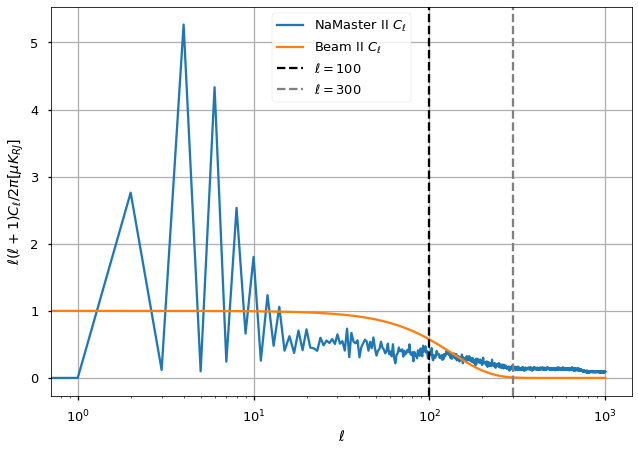

In [83]:
for c in ["II"]:
    plt.semilogx(cl_norm * cl[c], label=f"NaMaster {c} $C_\ell$")
    #plt.plot(cl_norm * cl[c] / w_ell**2, label=f"NaMaster {c} $C_\ell$")
    plt.plot(w_ell**2,  label=f"Beam {c} $C_\ell$")
plt.axvline(ell_fit_low, linestyle="--", color="black", label="$ \ell={} $".format(ell_fit_low))
plt.axvline(ell_fit_high, linestyle="--", color="gray", label="$ \ell={} $".format(ell_fit_high))
plt.legend()
plt.ylabel("$\ell(\ell+1)C_\ell/2\pi [\mu K_{RJ}]$")
plt.xlabel(("$\ell$"))
#plt.ylim(1e-2, 1e2)
plt.grid();

In [84]:
from scipy.optimize import curve_fit

In [85]:
def model(ell, A, gamma):
    return A + np.log(ell) * gamma

In [86]:
xdata = np.arange(ell_fit_low, ell_fit_high)

/global/u2/z/zonca/condanamaster/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/global/u2/z/zonca/condanamaster/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/global/u2/z/zonca/condanamaster/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


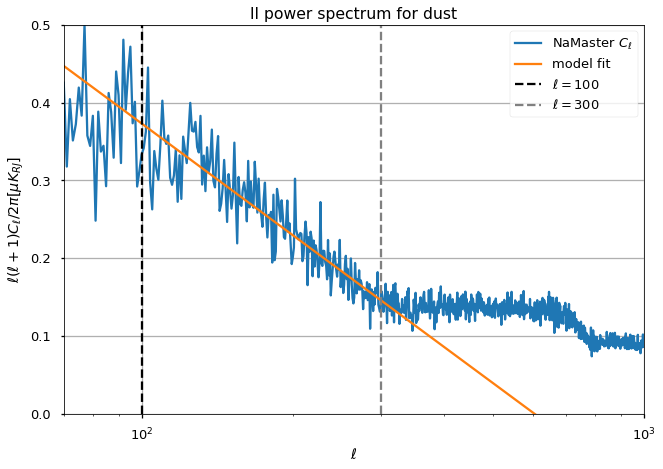

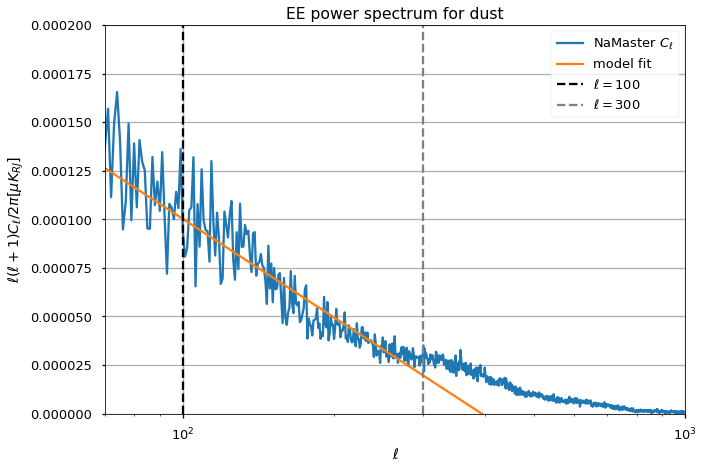

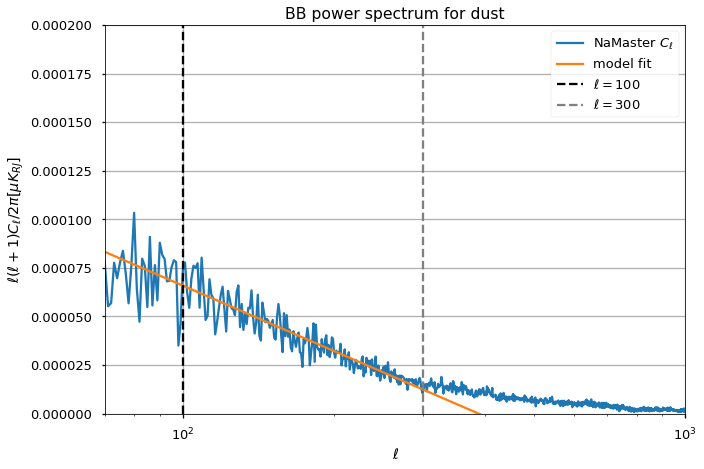

In [97]:
A_fit, gamma_fit, A_fit_std, gamma_fit_std = {},{},{},{}
for pol in spectra_components:
    ydata = xdata*(xdata+1)/np.pi/2 * cl[pol][xdata]
    (A_fit[pol], gamma_fit[pol]), cov = curve_fit(model, xdata, ydata)

    A_fit_std[pol], gamma_fit_std[pol] = np.sqrt(np.diag(cov))
    plt.figure()
    plt.semilogx(ell, ell*(ell+1)/np.pi/2 * cl[pol], label="NaMaster $C_\ell$")
    # plt.loglog(ell, ell*(ell+1)/np.pi/2 * cl_sigma_G[pol], label="SS $C_\ell$")

    plt.plot(ell, model(ell, A_fit[pol], gamma_fit[pol]), label="model fit")
    plt.axvline(ell_fit_low, linestyle="--", color="black", label="$ \ell={} $".format(ell_fit_low))
    plt.axvline(ell_fit_high, linestyle="--", color="gray", label="$ \ell={} $".format(ell_fit_high))
    plt.legend()
    plt.grid()
    plt.title(f"{pol} power spectrum for dust")
    plt.ylabel("$\ell(\ell+1)C_\ell/2\pi [\mu K_{RJ}]$")
    plt.xlabel(("$\ell$"))
    #plt.xlim(0, 400)
    #plt.ylim(1, 30);
    plt.xlim(ell_fit_low*.7, lmax)
    plt.ylim(0, 0.5 if pol == "II" else 2e-4)

In [90]:
A_fit, A_fit_std

({'II': 1.3284802862831049,
  'EE': 0.0004371709907628204,
  'BB': 0.0002896431199652955},
 {'II': 0.034228494454154414,
  'EE': 1.1883048844059395e-05,
  'BB': 6.823862920763207e-06})

In [91]:
gamma_fit, gamma_fit_std

({'II': -0.20742165073463292,
  'EE': -7.317403016949203e-05,
  'BB': -4.859319702211771e-05},
 {'II': 0.006508048517653064,
  'EE': 2.2593882438201347e-06,
  'BB': 1.297457921623411e-06})

## Load the smoothed GNILC map

Now that we have fitted the small scales behaviour on the GNILC map at higher resolution, we load the GNILC smoothed map,
at 80 arcminutes and fill in the small scale fluctiaitons on that map.

In [ ]:
dust_map_smoothed_filename = "COM_CompMap_IQU-thermaldust-gnilc-unires_2048_R3.00.fits"

In [ ]:
if not os.path.exists(dust_map_smoothed_filename):
    !wget -O $dust_map_filename http://pla.esac.esa.int/pla/aio/product-action?MAP.MAP_ID=$dust_map_smoothed_filename

In [ ]:
m_planck_smoothed = hp.read_map(dust_map_smoothed_filename, (0,1,2))

In [ ]:
if comp == "I":
    m_planck_smoothed = m_planck_smoothed[:1]
else:
    m_planck_smoothed[0] = 0

In [ ]:
m_planck_smoothed <<= u.K_CMB

In [ ]:
m_planck_smoothed = m_planck_smoothed.to("uK_RJ", equivalencies=u.cmb_equivalencies(353*u.GHz))

In [ ]:
hp.mollview(m_planck_smoothed[0])

### Window function

The window function is used to smooth the input templates to remove the high $\ell$ noise and its inverse is used for the added small scales.

In the PySM 2 paper, smoothing was at 2.6 degrees. Here we just use the GNILC map at uniform resolution of 80 arcminutes.

In [ ]:
theta_fwhm_deg = 80/60 # 80 arcmin

In [ ]:
theta_fwhm_deg

In [ ]:
180/theta_fwhm_deg

In [ ]:
theta_fwhm = np.radians(theta_fwhm_deg)

In [ ]:
w_ell = hp.gauss_beam(fwhm=theta_fwhm, lmax=5*lmax)

In [ ]:
w_ell.shape

In [ ]:
inv_w_ell = 1 - w_ell**2

In [ ]:
plt.loglog(w_ell**2)
plt.loglog(inv_w_ell)
plt.axvline(180/theta_fwhm_deg, color="black", linestyle="--")
plt.grid()
plt.xlim([1,1000])
plt.ylim([1e-2, 1e2])

## Simulate a realization of small scales fluctuations

We simulate small scales fluctuations using the inverse of the window function and the fitted amplitude and slope.
Also fix the seed to make this reproducible.

In [ ]:
np.random.seed(777 * len(comp))

In [ ]:
zeros = np.zeros(len(ell), dtype=np.double)

In [ ]:

if comp == "I":
    cl_in = A_fit["II"] * ell**gamma_fit["II"] * inv_w_ell / cl_norm
    cl_in[0] = 0
    m_sigma_G = hp.synfast(
    cl_in, nside, new=True)
    del cl_in
else:
    cl_EE = A_fit["EE"] * ell**gamma_fit["EE"] * inv_w_ell / cl_norm
    cl_EE[0] = 0
    cl_BB = A_fit["BB"] * ell**gamma_fit["BB"] * inv_w_ell / cl_norm
    cl_BB[0]=0
    m_sigma_G = hp.synfast([
    zeros,
    cl_EE,
    cl_BB,
    zeros, zeros, zeros], nside, new=True)


In [ ]:
assert(not np.any(np.isnan(m_sigma_G)))

## Write output map

We write the output map, GNILC smoothed at 80 arcmin + the small scale fluctuations

In [ ]:
m_total = m_planck_smoothed.value + m_sigma_G

In [ ]:
m_total.shape

In [ ]:
hp.write_map(f"gnilc_plus_smallscales_{comp}.fits", m_total, overwrite=True)

## Scale the small scale fluctuations with large scale amplitude

As described in the PySM 2 paper, we compute the power spectrum in every patch e.g. pixel at $N_{side}=2$, and then scale the small scale fluctuations so that they agree with the power at large scale (we use a specific $\ell$ to make the comparison, in the paper it is 69, here we are doing less smoothing so we use a higher ell, see `ell_star`.

This process doesn't have a large impact on the output spectra, the idea is that in each $N_{side}=2$ pixel we want to scale the gaussian fluctuations so that they are consistent with the power at low ell.
So we will have higher gaussian fluctuations on the galaxy where there is stronger dust emission.

$$
N(\boldsymbol{\hat{n}}) = \sqrt{\dfrac{C_{\ell_*}(\boldsymbol{\hat{n}})}{A\ell_*^\gamma}}
$$

In [ ]:
ell_star

In [ ]:
patch_indices = hp.ud_grade(np.arange(hp.nside2npix(2)), nside)

In [ ]:
hp.mollview(patch_indices)

In [ ]:
nside_patches = 2
n_patches = hp.nside2npix(nside_patches)

In [ ]:
i_pols = [1,2] if comp == "QU" else [0]

In [ ]:
pols = list(zip(spectra_components, i_pols))

In [ ]:
N = {i_pol:np.zeros(n_patches, dtype=np.double) for i_pol in i_pols}

In [ ]:
for i_patch in range(n_patches):
    print(i_patch)
    m_patch = np.zeros_like(m_planck_smoothed)
    m_patch[:, patch_indices == i_patch] = m_planck_smoothed[:, patch_indices == i_patch]
    # m_patch = hp.smoothing(m_patch[0], fwhm=np.radians(10), lmax=2*ell_star)
    cl_patch = hp.anafast(m_patch, lmax=2*ell_star, use_pixel_weights=True)
    if cl_patch.ndim == 1:
        cl_patch = cl_patch.reshape((1,-1))
    for pol,i_pol in pols:
        N[i_pol][i_patch] = np.sqrt(cl_patch[i_pol][ell_star] / n_patches / (A_fit[pol] * ell_star ** gamma_fit[pol]))

In [ ]:
N

In [ ]:
for k,v in N.items():
    hp.mollview(v, title=k)

In [ ]:
m_zeros = np.zeros(hp.nside2npix(nside), dtype=np.double)

In [ ]:
m_N = [N[0]] if comp == "I" else [np.zeros(len(N[1])), N[1], N[2]]
hp.write_map(f"N_{comp}.fits", m_N, overwrite=True)

In [ ]:
# N = hp.read_map("N.fits", (0,1,2))

In [ ]:
N_smoothed = hp.smoothing(hp.ud_grade(m_N[0], nside) if comp=="I" else hp.ud_grade(m_N, nside), lmax=lmax, fwhm=np.radians(10))

In [ ]:
if N_smoothed.ndim == 1:
    N_smoothed = N_smoothed.reshape((1,-1))

In [ ]:
hp.write_map(f"N_smoothed_{comp}.fits", N_smoothed, overwrite=True)
# N_smoothed = hp.read_map("N_smoothed.fits", (0,1,2))

In [ ]:
for i_pol in i_pols:
    N_smoothed[i_pol] /= (N_smoothed[i_pol]).mean()

In [ ]:
hp.write_map(f"N_smoothed_normalized_{comp}.fits", N_smoothed, overwrite=True)
# N_smoothed = hp.read_map("N_smoothed.fits", (0,1,2))

In [ ]:
for i_pol, pol in enumerate("IQU"):
    hp.mollview(N_smoothed[i_pol,:], title=pol)

In [ ]:
m_total = m_planck_smoothed.value + m_sigma_G * N_smoothed

In [ ]:
hp.write_map(f"gnilc_plus_smallscales_scaled_{comp}.fits", m_total, overwrite=True)

# 